In [171]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error # as cost function, to be used in RMSE
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz  
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import datetime
import time
seed = 0 # initialize consistent random_state

In [172]:
import pydotplus
from IPython.display import Image
# graph = pydotplus.graph_from_dot_data(dot_data)
# Image(graph.create_png())

In [173]:
raw_df = pd.read_csv('cleaned_wonder_plus_2021.csv')
holdout_2021 = raw_df[raw_df['Year'] == 2021].copy()
# cleaned = raw_df[raw_df['Year'] < 2021].copy()
# cleaned['Year'].value_counts()
cleaned = raw_df.copy()
cleaned['Crude Rate'] = cleaned['Crude Rate'].fillna(0) # .replace(0, 0.001)
cleaned['Crude Rate'].value_counts(dropna = False)
# cleaned

Crude Rate
0.000000     4440
2.500000       15
2.400000       12
1.749647       12
2.100000       10
             ... 
3.760578        1
1.376828        1
32.090366       1
7.506493        1
0.360194        1
Name: count, Length: 17202, dtype: int64

In [174]:
# only 2021 data has NaNs for Crude Rate. This does
before_2021 = raw_df[raw_df['Year'] < 2021].copy()
before_2021['Crude Rate'].value_counts(dropna = False)

Crude Rate
1.749647     12
1.725483      9
26.252231     9
2.039268      8
20.696221     8
             ..
1.893803      1
2.283783      1
1.518330      1
1.953066      1
0.376234      1
Name: count, Length: 16242, dtype: int64

In [175]:
fentanyl = cleaned[cleaned['Multiple Cause of death'] == 'Other synthetic narcotics'].copy()
fentanyl

,Multiple Cause of death,Multiple Cause of death Code,Year,Year Code,Gender,Gender Code,Race,Race Code,Five-Year Age Groups,Five-Year Age Groups Code,Deaths,Population,Crude Rate,socioec quintile,age_midpoint
3548,Other synthetic narcotics,T40.4,1999,1999,Female,F,American Indian or Alaska Native,1002-5,25-29 years,25-29,5,35278,14.173139,1.0,27.0
3549,Other synthetic narcotics,T40.4,1999,1999,Female,F,American Indian or Alaska Native,1002-5,40-44 years,40-44,5,38192,13.091747,1.0,42.0
3550,Other synthetic narcotics,T40.4,1999,1999,Female,F,Asian or Pacific Islander,A-PI,40-44 years,40-44,5,28791,17.366538,1.0,42.0
3551,Other synthetic narcotics,T40.4,1999,1999,Female,F,Asian or Pacific Islander,A-PI,45-49 years,45-49,5,26161,19.112419,1.0,47.0
3552,Other synthetic narcotics,T40.4,1999,1999,Female,F,Black or African American,2054-5,20-24 years,20-24,5,369758,1.352236,1.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34501,Other synthetic narcotics,T40.4,2021,2021,Male,M,More than one race,M,60-64 years,60-64,5,31440,15.903308,5.0,62.0
34502,Other synthetic narcotics,T40.4,2021,2021,Male,M,More than one race,M,65-69 years,65-69,5,22668,22.057526,5.0,67.0
34503,Other synthetic narcotics,T40.4,2021,2021,Male,M,More than one race,M,70-74 years,70-74,5,15352,32.569046,5.0,72.0
34504,Other synthetic narcotics,T40.4,2021,2021,Male,M,More than one race,M,75-79 years,75-79,0,8905,0.000000,5.0,77.0


# Manage Outliers
Do we want to ignore outliers? They are some of the few data points where we have actual data and are not using our artificial "suppressed" average of 5 deaths. 

We can do this per socioeconomic quintile or any of the other features, but I do so for the entire dataset

For now, I identify using the IQR and consider anything outside the 1.5 * upper or lower bounds as an outlier. We can also do 3 standard deviations away

In [176]:
# identify interquartile range as the bounds
fentanyl_outliers_working = fentanyl.copy()

# set opiod index to column to reset index
fentanyl_outliers_working['narcotics_index'] = fentanyl_outliers_working.index
fentanyl_outliers_working = fentanyl_outliers_working.reset_index(drop = True) #reset_index creates redundant index col

# calculate upper and lower bounds
print(f'Original data shape: {fentanyl.shape[0]}')
Q1 = fentanyl_outliers_working['Crude Rate'].quantile(0.25)
Q3 = fentanyl_outliers_working['Crude Rate'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - (1.5 * IQR)
upper = Q3 + (1.5 * IQR)
 
# indices of outlier rows
outliers_beyond_upper = np.where(fentanyl_outliers_working['Crude Rate'] >= upper)[0]
outliers_beyond_lower = np.where(fentanyl_outliers_working['Crude Rate'] <= lower)[0]
# print(outliers_beyond_lower)
# print(outliers_beyond_upper)
outliers_arr = np.append(outliers_beyond_upper , outliers_beyond_lower)
print(f'Number of outliers: {len(outliers_arr)}')
# fentanyl_working
fentanyl_outliers_removed = fentanyl_outliers_working.drop(index = outliers_arr)
fentanyl_outliers_removed

Original data shape: 6658
Number of outliers: 499


,Multiple Cause of death,Multiple Cause of death Code,Year,Year Code,Gender,Gender Code,Race,Race Code,Five-Year Age Groups,Five-Year Age Groups Code,Deaths,Population,Crude Rate,socioec quintile,age_midpoint,narcotics_index
0,Other synthetic narcotics,T40.4,1999,1999,Female,F,American Indian or Alaska Native,1002-5,25-29 years,25-29,5,35278,14.173139,1.0,27.0,3548
1,Other synthetic narcotics,T40.4,1999,1999,Female,F,American Indian or Alaska Native,1002-5,40-44 years,40-44,5,38192,13.091747,1.0,42.0,3549
2,Other synthetic narcotics,T40.4,1999,1999,Female,F,Asian or Pacific Islander,A-PI,40-44 years,40-44,5,28791,17.366538,1.0,42.0,3550
3,Other synthetic narcotics,T40.4,1999,1999,Female,F,Asian or Pacific Islander,A-PI,45-49 years,45-49,5,26161,19.112419,1.0,47.0,3551
4,Other synthetic narcotics,T40.4,1999,1999,Female,F,Black or African American,2054-5,20-24 years,20-24,5,369758,1.352236,1.0,22.0,3552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6652,Other synthetic narcotics,T40.4,2021,2021,Male,M,More than one race,M,55-59 years,55-59,5,36635,13.648151,5.0,57.0,34500
6653,Other synthetic narcotics,T40.4,2021,2021,Male,M,More than one race,M,60-64 years,60-64,5,31440,15.903308,5.0,62.0,34501
6654,Other synthetic narcotics,T40.4,2021,2021,Male,M,More than one race,M,65-69 years,65-69,5,22668,22.057526,5.0,67.0,34502
6656,Other synthetic narcotics,T40.4,2021,2021,Male,M,More than one race,M,75-79 years,75-79,0,8905,0.000000,5.0,77.0,34504


# Decide dataset to use
Can use either fentanyl_outliers_removed or original fentanyl, but set fentanyl_bronze as starting "dataset to be used throughout"

For now, predict only crude rate (y), but we can do all the same below by switching to life years lost

In [177]:
# features and labels
x_cols = ['Year', 'Gender', 'Race', 'Five-Year Age Groups', 'Population', 'socioec quintile']
y_col = ['Crude Rate']

# select dataset to use
fentanyl_bronze = fentanyl.loc[:, np.append(x_cols, y_col)].copy() #or #fentanyl_outliers_removed.copy()
# fentanyl_bronze.reset_index(inplace = True, drop = True).drop()
fentanyl_bronze

,Year,Gender,Race,Five-Year Age Groups,Population,socioec quintile,Crude Rate
3548,1999,Female,American Indian or Alaska Native,25-29 years,35278,1.0,14.173139
3549,1999,Female,American Indian or Alaska Native,40-44 years,38192,1.0,13.091747
3550,1999,Female,Asian or Pacific Islander,40-44 years,28791,1.0,17.366538
3551,1999,Female,Asian or Pacific Islander,45-49 years,26161,1.0,19.112419
3552,1999,Female,Black or African American,20-24 years,369758,1.0,1.352236
...,...,...,...,...,...,...,...
34501,2021,Male,More than one race,60-64 years,31440,5.0,15.903308
34502,2021,Male,More than one race,65-69 years,22668,5.0,22.057526
34503,2021,Male,More than one race,70-74 years,15352,5.0,32.569046
34504,2021,Male,More than one race,75-79 years,8905,5.0,0.000000


In [266]:
fentanyl_bronze['Five-Year Age Groups'].value_counts(dropna = False)

Five-Year Age Groups
45-49 years     579
40-44 years     571
50-54 years     544
35-39 years     538
25-29 years     517
30-34 years     513
55-59 years     502
20-24 years     482
60-64 years     408
15-19 years     376
65-69 years     346
70-74 years     296
75-79 years     266
80-84 years     215
1-4 years       163
10-14 years     146
< 1 year        116
5-9 years        80
Name: count, dtype: int64

In [178]:
fentanyl_silver = pd.get_dummies(fentanyl_bronze)
fentanyl_silver

,Year,Population,socioec quintile,Crude Rate,Gender_Female,Gender_Male,Race_American Indian or Alaska Native,Race_Asian or Pacific Islander,Race_Black or African American,Race_More than one race,...,Five-Year Age Groups_45-49 years,Five-Year Age Groups_5-9 years,Five-Year Age Groups_50-54 years,Five-Year Age Groups_55-59 years,Five-Year Age Groups_60-64 years,Five-Year Age Groups_65-69 years,Five-Year Age Groups_70-74 years,Five-Year Age Groups_75-79 years,Five-Year Age Groups_80-84 years,Five-Year Age Groups_< 1 year
3548,1999,35278,1.0,14.173139,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3549,1999,38192,1.0,13.091747,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3550,1999,28791,1.0,17.366538,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3551,1999,26161,1.0,19.112419,True,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
3552,1999,369758,1.0,1.352236,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34501,2021,31440,5.0,15.903308,False,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
34502,2021,22668,5.0,22.057526,False,True,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
34503,2021,15352,5.0,32.569046,False,True,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
34504,2021,8905,5.0,0.000000,False,True,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False


# Split data into test/train

In [179]:
x = fentanyl_silver.drop(y_col, axis = 1) # get only features
y = fentanyl_silver.loc[:, y_col]

x
# y

,Year,Population,socioec quintile,Gender_Female,Gender_Male,Race_American Indian or Alaska Native,Race_Asian or Pacific Islander,Race_Black or African American,Race_More than one race,Race_White,...,Five-Year Age Groups_45-49 years,Five-Year Age Groups_5-9 years,Five-Year Age Groups_50-54 years,Five-Year Age Groups_55-59 years,Five-Year Age Groups_60-64 years,Five-Year Age Groups_65-69 years,Five-Year Age Groups_70-74 years,Five-Year Age Groups_75-79 years,Five-Year Age Groups_80-84 years,Five-Year Age Groups_< 1 year
3548,1999,35278,1.0,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3549,1999,38192,1.0,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3550,1999,28791,1.0,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3551,1999,26161,1.0,True,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3552,1999,369758,1.0,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34501,2021,31440,5.0,False,True,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
34502,2021,22668,5.0,False,True,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
34503,2021,15352,5.0,False,True,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
34504,2021,8905,5.0,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False


In [180]:
# train/test set at 80/20 split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)
print(f'Training Features Shape: {x_train.shape}')
print(f'Training Labels Shape:  {x_test.shape}')
print(f'Testing Features Shape: {y_train.shape}')
print(f'Testing Labels Shape: {y_test.shape}')

Training Features Shape: (5326, 28)
Training Labels Shape:  (1332, 28)
Testing Features Shape: (5326, 1)
Testing Labels Shape: (1332, 1)


In [181]:
test_df = x_test.merge(y_test, left_index = True, right_index = True) #merge on index 
test_df

,Year,Population,socioec quintile,Gender_Female,Gender_Male,Race_American Indian or Alaska Native,Race_Asian or Pacific Islander,Race_Black or African American,Race_More than one race,Race_White,...,Five-Year Age Groups_5-9 years,Five-Year Age Groups_50-54 years,Five-Year Age Groups_55-59 years,Five-Year Age Groups_60-64 years,Five-Year Age Groups_65-69 years,Five-Year Age Groups_70-74 years,Five-Year Age Groups_75-79 years,Five-Year Age Groups_80-84 years,Five-Year Age Groups_< 1 year,Crude Rate
20714,2009,261047,4.0,True,False,False,False,True,False,False,...,False,True,False,False,False,False,False,False,False,1.915364
10200,2020,407651,2.0,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,42.192954
26197,2003,1458456,5.0,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,0.342828
26611,2014,264937,5.0,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,1.887241
29168,2021,3582,1.0,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15607,2019,31079,3.0,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,16.088034
9509,2009,1658036,2.0,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,2.291868
4074,2011,46808,1.0,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,10.681935
21347,2019,400461,4.0,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,21.724962


# Compare against using simple average
Compare any models against the error calculated from the simple average crude rate for the quintile

In [182]:
test_averages = test_df.groupby('socioec quintile', as_index = False).agg(quintile_ave = ('Crude Rate', 'mean'))
test_averages

,socioec quintile,quintile_ave
0,1.0,8.420042
1,2.0,7.762782
2,3.0,10.637413
3,4.0,7.781231
4,5.0,8.723380


In [183]:
test_df_ave_preds = test_df.merge(test_averages, on = 'socioec quintile')
print(f'Test df shape: {test_df_ave_preds.shape[0]}')

Test df shape: 1332


Finding the root mean square error involves calculating the residual for each observation (y – ŷ) and squaring it. Then sum all the squared residuals. Divide that sum by the error degrees of freedom in your model (N – P) to find the average squared residual, more technically known as the mean squared error (MSE). Finally, take the square root to find the RSME.

In [184]:
# calculate root mean squared error: 
test_df_ave_preds['residual'] = (test_df_ave_preds['quintile_ave'] - test_df_ave_preds['Crude Rate'])**2

rmse = round(np.sqrt(np.mean(test_df_ave_preds['residual'])), 2)
print(f'Root mean squared error error: {rmse}')
test_df_ave_preds
# Average baseline error:  5.06 degrees.

Root mean squared error error: 14.14


,Year,Population,socioec quintile,Gender_Female,Gender_Male,Race_American Indian or Alaska Native,Race_Asian or Pacific Islander,Race_Black or African American,Race_More than one race,Race_White,...,Five-Year Age Groups_55-59 years,Five-Year Age Groups_60-64 years,Five-Year Age Groups_65-69 years,Five-Year Age Groups_70-74 years,Five-Year Age Groups_75-79 years,Five-Year Age Groups_80-84 years,Five-Year Age Groups_< 1 year,Crude Rate,quintile_ave,residual
0,2009,261047,4.0,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,1.915364,7.781231,34.408392
1,2017,1359748,4.0,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,0.367715,7.781231,54.960210
2,2010,33791,4.0,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,14.796839,7.781231,49.218767
3,2021,37665,4.0,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,13.274924,7.781231,30.180664
4,2016,1663317,4.0,False,True,False,False,False,False,True,...,False,True,False,False,False,False,False,5.711479,7.781231,4.283872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,2007,329604,3.0,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,1.516972,10.637413,83.182455
1328,2007,293847,3.0,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,1.701566,10.637413,79.849374
1329,2021,27631,3.0,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,18.095617,10.637413,55.624804
1330,2015,1536628,3.0,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,6.312523,10.637413,18.704678


##### Example Decision Tree (DT) Visualization 
The actual dts are too big, so shortening data to include as an example

In [185]:
# x_train.iloc[:,[0:5]]

In [186]:
# # attempt to visualize example DT
# dec_tree_example = DecisionTreeRegressor(random_state = seed)

# # Fitting the Decision Tree Regression model to the data
# dec_tree_example.fit(x_train[0:5,:], y_train)

# # export the decision tree model to a tree_structure.dot file 
# # paste the contents of the file to webgraphviz.com
# dot_data = export_graphviz(dec_tree_example, out_file = None, 
#                feature_names =x_train.columns, filled = True) #out_file ='tree_structure.dot'
# graph = pydotplus.graphviz.graph_from_dot_data(dot_data)
# Image(graph.create_png())

# Single Decision Tree

In [187]:
dec_tree_reg = DecisionTreeRegressor(random_state = seed)

# Fitting the Decision Tree Regression model to the data
dec_tree_reg.fit(x_train, y_train)
dec_tree_name = "Base Decision Tree"

In [188]:
# Predicting the target values of the test set
y_pred = dec_tree_reg.predict(x_test)
y_pred
y_test
# RMSE (Root Mean Square Error)
# rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))

mse = np.square(np.subtract(y_test['Crude Rate'], y_pred)).mean()
rmse = math.sqrt(mse)
# rmse = round(np.sqrt((np.mean(y_test['Crude Rate'] - y_pred) ** 2)/2), 2)
rmse_oob = round(mean_squared_error(y_test['Crude Rate'], y_pred, squared = False), 2) #testing out-of-box caclulation of mse. squared=False: return RMSE
print("RMSE: ", rmse)
print("RMSE OOB: ", rmse_oob)
y_test

RMSE:  8.996980168757533
RMSE OOB:  9.0


,Crude Rate
20714,1.915364
10200,42.192954
26197,0.342828
26611,1.887241
29168,0.000000
...,...
15607,16.088034
9509,2.291868
4074,10.681935
21347,21.724962


In [189]:
test_joined = x_test.join(y_test).rename(columns = {'Crude Rate': 'Actual Crude Rate'})
test_joined['Predicted Crude Rate'] = y_pred #
test_joined

,Year,Population,socioec quintile,Gender_Female,Gender_Male,Race_American Indian or Alaska Native,Race_Asian or Pacific Islander,Race_Black or African American,Race_More than one race,Race_White,...,Five-Year Age Groups_50-54 years,Five-Year Age Groups_55-59 years,Five-Year Age Groups_60-64 years,Five-Year Age Groups_65-69 years,Five-Year Age Groups_70-74 years,Five-Year Age Groups_75-79 years,Five-Year Age Groups_80-84 years,Five-Year Age Groups_< 1 year,Actual Crude Rate,Predicted Crude Rate
20714,2009,261047,4.0,True,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,1.915364,1.918451
10200,2020,407651,2.0,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,42.192954,43.101828
26197,2003,1458456,5.0,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,0.342828,0.342654
26611,2014,264937,5.0,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,1.887241,1.889281
29168,2021,3582,1.0,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15607,2019,31079,3.0,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,16.088034,16.070453
9509,2009,1658036,2.0,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,2.291868,2.298180
4074,2011,46808,1.0,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,10.681935,10.729153
21347,2019,400461,4.0,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,21.724962,18.032444


In [190]:
y_pred

array([ 1.91845051, 43.101828  ,  0.34265421, ..., 10.72915326,
       18.032444  , 20.51871307])

In [191]:
##### test time for permutation_importance
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

### horizontal bar chart of feature importances using mean decrease in impurity - may not be ideal
def rate_features_impurity(x, trained_model):
    features = x.columns
    f_i = list(zip(features,trained_model.feature_importances_))
    f_i.sort(key = lambda x : x[1])
    plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
    plt.show()

def rate_features_permutation(trained_model, x_train, x_test, y_pred, model_name = "base model name"):
    feature_names = x_train.columns

    start_time = time.time()
    # permutation_importance is better than the mean decrease in impurity (.feature_importances_) because of high cardinality
    result = permutation_importance(
        trained_model, x_test, y_pred, n_repeats=10, random_state=42, n_jobs=2
    )
    elapsed_time = time.time() - start_time 
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")  # for single decision tree 0.597 seconds

    model_importance = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending = False)
    # dec_tree_importance = pd.Series(importances, index=feature_names)

    feature_df = pd.DataFrame({'feature_names': feature_names, 'importance':result.importances_mean})
    feature_df.to_csv(f"Feature_Importance_{model_name}.csv", index = False)
    fig, ax = plt.subplots()
    model_importance.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title(f"Feature Importances on {model_name}")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()

Elapsed time to compute the importances: 4.977 seconds


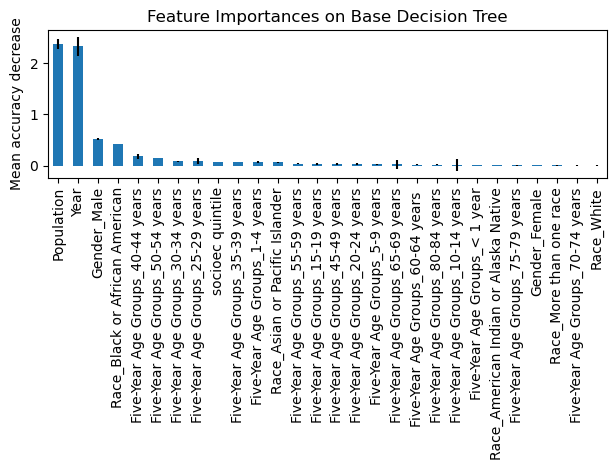

In [192]:
rate_features_permutation(dec_tree_reg, x_train, x_test, y_pred, model_name = dec_tree_name)

In [193]:
# TODO: evaluate data on 2021 data. So massage holdout_2021
def evaluate_on_2021():
    pass

RMSE for Base Decision Tree is 7.421
Not None


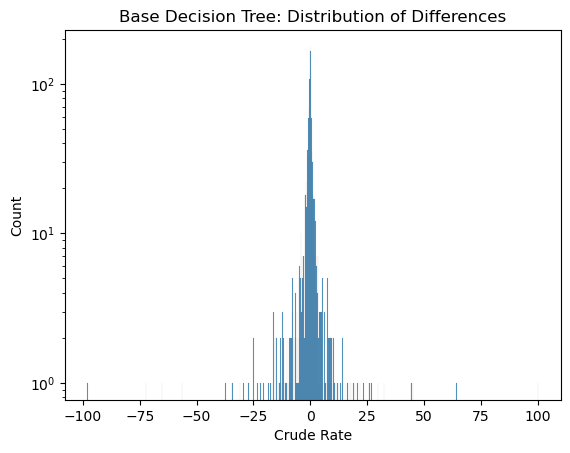

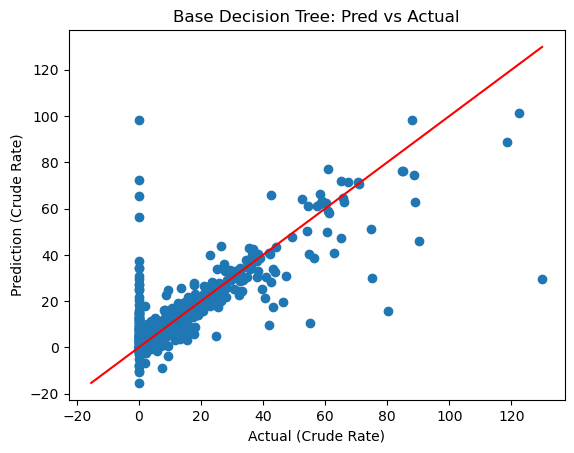

In [233]:
# visualize prediction vs actual: histplot and scatterplot (to visually inspect how model does)
# y_actual: array-like of actual predictions
def evaluate_model(y_pred, y_actual, model_name = 'default_model',  x_test = None):
    rmse = round(mean_squared_error(y_actual, y_pred, squared = False), 4)
    print(f"RMSE for {model_name} is {rmse}")
    
#     plt.figure(figsize=(16,4))
    if x_test is not None:
        print("Not None")
        # TODO: fix these graphs 1 row, 3 col visual
#         fig, axes = plt.subplots(1,3, figsize = (16,4))
#         axes[0].set_yscale('log') # set histplot on log scale to visualize - relatively bell-curved
#     #     axes[0].set_xscale('log')
#         sns.histplot(y_actual-y_pred, ax = axes[0])
#         plt.scatter(y_actual,y_pred, ax = axes[1])
#         p1 = max(max(y_pred), max(y_actual))
#         p2 = min(min(y_pred), min(y_actual))
#         plt.plot([p1, p2], [p1, p2], 'b-')
        
#         plt.scatter(x_test.values, y_test, color = 'red', ax = axes[2] )
#         plt.scatter(x_test.values, y_pred, color = 'green', ax = axes[2])
#         plt.show()
        
        # 1 row, 2 col visual
#         print("X_test is empty")
#         fig, axes = plt.subplots(1,2, figsize = (16,4))
#         axes[0].set_yscale('log') # set histplot on log scale to visualize - relatively bell-curved
#         axes[0].set_xscale('log')
        plt.yscale('log') # log b/c the majority of predictions = actual, so diff = 0 for majority

        plt.title(model_name + ': Distribution of Differences')
        sns.histplot(y_actual-y_pred)#, ax = axes[0])
        plt.show()
        
        
        fig, ax = plt.subplots()
        plt.title(model_name + ': Pred vs Actual')
        plt.scatter(y_actual,y_pred)
        ax.set_ylabel('Prediction (Crude Rate)')
        ax.set_xlabel('Actual (Crude Rate)')
        p1 = max(max(y_pred), max(y_actual))
        p2 = min(min(y_pred), min(y_actual))
        plt.plot([p1, p2], [p1, p2], 'r-') #b- for blue line instead
        
        plt.show()
        
        # export actuals and predictions for "smoothing" evaluations. Simple output and complete output (including features)
        y_output = pd.DataFrame({"actual": y_actual, "predictions": y_pred})
        y_output.to_csv(f"Simple_{model_name}_ActualVSPred_RMSE_{rmse}.csv", index = False)
        
        y_output_full = x_test.join(y_actual).rename(columns = {'Crude Rate': 'Actual Crude Rate'})
        y_output_full['Predicted Crude Rate'] = y_pred #
        y_output_full.to_csv(f"Full_{model_name}_ActualVSPred_RMSE_{rmse}.csv", index = False)
        
    else: 
        # 1 row, 2 col visual
#         print("X_test is empty")
#         fig, axes = plt.subplots(1,2, figsize = (16,4))
#         axes[0].set_yscale('log') # set histplot on log scale to visualize - relatively bell-curved
#         axes[0].set_xscale('log')
        plt.yscale('log') # log b/c the majority of predictions = actual, so diff = 0 for majority

        plt.title(model_name + ': Distribution of Differences')
        sns.histplot(y_actual-y_pred)#, ax = axes[0])
        plt.show()
        
        
        fig, ax = plt.subplots()
        plt.title(model_name + ': Pred vs Actual')
        plt.scatter(y_actual,y_pred)
        ax.set_ylabel('Prediction (Crude Rate)')
        ax.set_xlabel('Actual (Crude Rate)')
        p1 = max(max(y_pred), max(y_actual))
        p2 = min(min(y_pred), min(y_actual))
        plt.plot([p1, p2], [p1, p2], 'r-') #b- for blue line instead
        
        plt.show()
        
        # export actuals and predictions for "smoothing" evaluations. Simple output and complete output (including features)
        y_output = pd.DataFrame({"actual": y_test['Crude Rate'], "predictions": y_pred})
        y_output.to_csv(f"Simple_{model_name}_ActualVSPred_RMSE_{rmse}.csv", index = False)
        


# evaluate_model(y_pred, y_test['Crude Rate'], x_test['Population'].values,"base decision tree model")
evaluate_model(y_pred, y_test['Crude Rate'],  model_name = dec_tree_name, x_test=x_test)



(process:30492): GLib-GIO-WARNING **: 14:21:27.298: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2309.16.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs

(process:30492): GLib-GIO-WARNING **: 14:21:27.357: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.8.3.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0661998 to fit



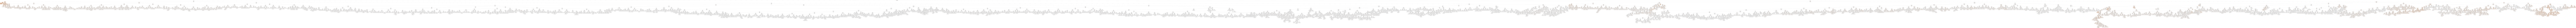

In [195]:
# export the decision tree model to a tree_structure.dot file - paste the contents of the file to webgraphviz.com
# NOTE: too large to visualize appropriately, may need to do a smaller example
dot_data = export_graphviz(dec_tree_reg, out_file = None, 
               feature_names =x_train.columns, filled = True) #out_file ='tree_structure.dot'
graph = pydotplus.graphviz.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [196]:
x_train

,Year,Population,socioec quintile,Gender_Female,Gender_Male,Race_American Indian or Alaska Native,Race_Asian or Pacific Islander,Race_Black or African American,Race_More than one race,Race_White,...,Five-Year Age Groups_45-49 years,Five-Year Age Groups_5-9 years,Five-Year Age Groups_50-54 years,Five-Year Age Groups_55-59 years,Five-Year Age Groups_60-64 years,Five-Year Age Groups_65-69 years,Five-Year Age Groups_70-74 years,Five-Year Age Groups_75-79 years,Five-Year Age Groups_80-84 years,Five-Year Age Groups_< 1 year
30562,2021,70101,2.0,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
34324,2021,109245,5.0,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
9350,2006,206667,2.0,True,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
33087,2021,135795,4.0,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4439,2017,47309,1.0,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31820,2021,12280,3.0,False,True,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
26963,2019,354381,5.0,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9458,2008,1818406,2.0,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
21067,2016,205131,4.0,True,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False


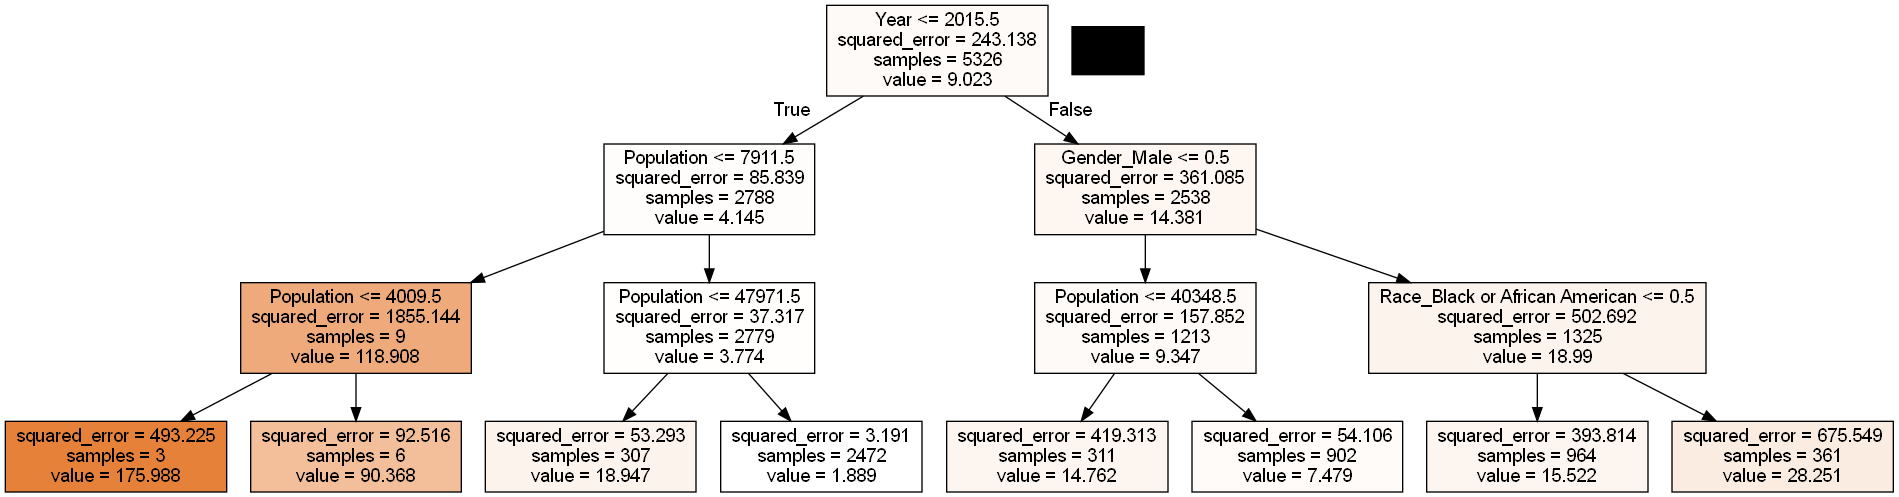

In [197]:
# visualize short tree as an example for pages
dec_tree_short_vis = DecisionTreeRegressor(random_state = seed, max_depth = 3)
dec_tree_short_vis.fit(x_train, y_train)
dot_data = export_graphviz(dec_tree_short_vis, out_file = None, 
               feature_names =x_train.columns, filled = True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [198]:
# hyperparameter tuning
# Reference: https://www.nbshare.io/notebook/312837011/Decision-Tree-Regression-With-Hyper-Parameter-Tuning-In-Python/
# Can also use ExtraTreesRegressor to be more selective in features, if we had more 
# parameters={"splitter":["best","random"],
#             "max_depth" : [1,3,5,7,9,11,12],
#            "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
#            "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
#            "max_features":["log2","sqrt",None],
#            "criterion": ['gini', 'entropy']
#            "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

parameters={ 
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "max_features":["log2","sqrt",None],
           "criterion": ['poisson', 'friedman_mse', 'squared_error'] }


# function for calculating how much time take for hyperparameter tuning

def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        print(thour,":",tmin,':',round(tsec,2))



In [199]:

start_time = datetime.now()
tuning_dec_tree = GridSearchCV(dec_tree_reg,param_grid=parameters,scoring='neg_mean_squared_error',cv=3) #,verbose=3)

tuning_dec_tree.fit(x_train, y_train)

timer(start_time)

0.0 : 0.0 : 13.88


{'criterion': 'poisson', 'max_depth': 12, 'max_features': None, 'min_samples_leaf': 5}
-111.78879604650363
RMSE for Tuned Decision Tree is 8.0885
Not None


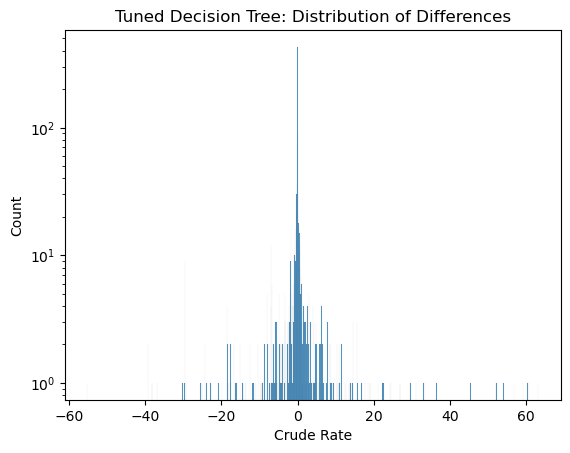

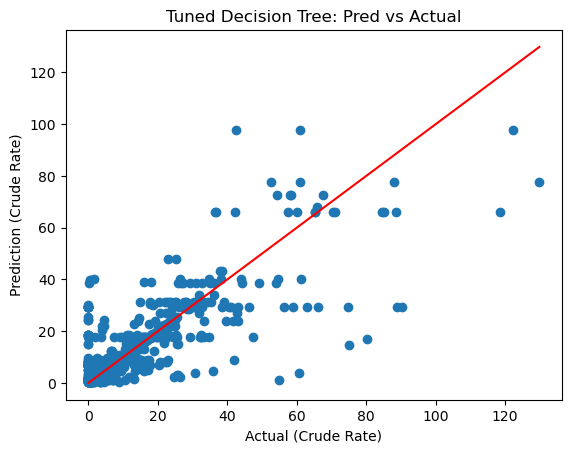

Elapsed time to compute the importances: 0.306 seconds


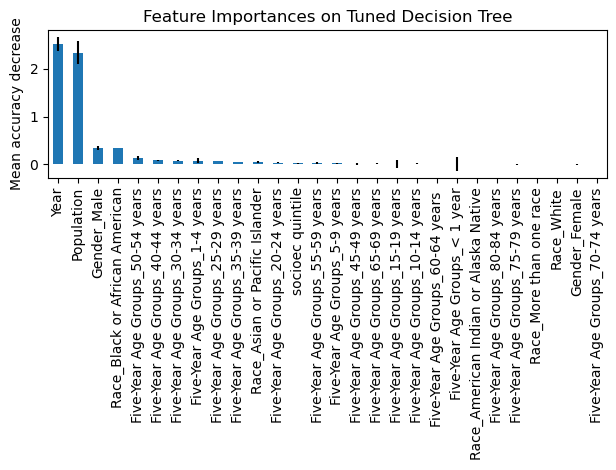

In [200]:
# best hyperparameters
print(tuning_dec_tree.best_params_)
print(tuning_dec_tree.best_score_)
tuned_dec_tree_name = "Tuned Decision Tree"
# predict then evaluate prediction
y_pred = tuning_dec_tree.predict(x_test)
evaluate_model(y_pred, y_test['Crude Rate'],  model_name = tuned_dec_tree_name, x_test = x_test)
rate_features_permutation(dec_tree_reg, x_train, x_test, y_pred, model_name = tuned_dec_tree_name)


### Best Decision Tree (DT)

In [201]:
# "best" decision tree from other set of parameters ends up with the below DT, with an RMSE of 7.7609....
# best_dt = DecisionTreeRegressor(random_state = seed, max_depth = 7, max_features = None,
#                                max_leaf_nodes = None, min_samples_leaf = 1,
#                                 min_weight_fraction_leaf = 0.1, splitter = 'best')
# best_dt.fit(x_train, y_train)
# best_dt_name = "Best Decision Tree"
# best_dt

In [202]:
# predict then evaluate prediction
# y_pred = best_dt.predict(x_test)
# evaluate_model(y_pred, y_test['Crude Rate'],  model_name = best_dt_name)
# rate_features_permutation(dec_tree_reg, x_train, x_test, y_pred, model_name = best_dt_name)

In [203]:
# export_graphviz(best_dt, out_file ='best_tree_structure.dot', 
#                feature_names =x_train.columns)
# graph = pydotplus.graph_from_dot_data(dot_data)
# Image(graph.create_png())

# Random Forest

In [204]:
# random forest with 1000 decision trees
rf_base = RandomForestRegressor(n_estimators = 100, random_state = seed) #sklearn's RF

rf_base.fit(x_train, y_train['Crude Rate'])
rf_base_name = 'Random Forest Initial Model'
# use this model instead if you want to use "out-of-bag" samples to estimate R^2 on unseen data 
# generally, if > 0.75, model will generalize well
# rf_out_of_bag = RandomForestRegressor(n_estimators = 1000, random_state = seed, oob_score = True) 
# rf_out_of_bag.fit(x_train, y_train)
# print(rf_out_of_bag.oob_score_) 

RMSE for Random Forest Initial Model is 6.8805
Not None


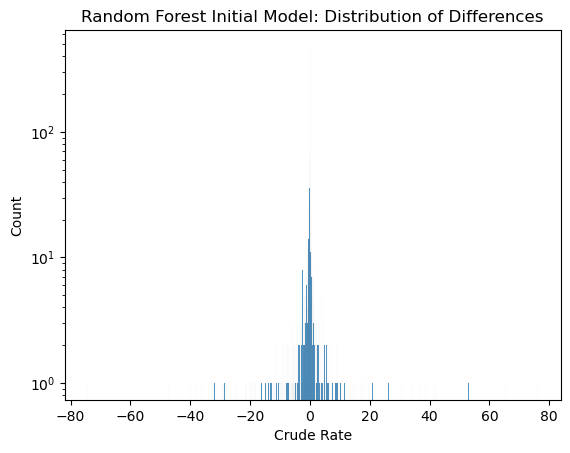

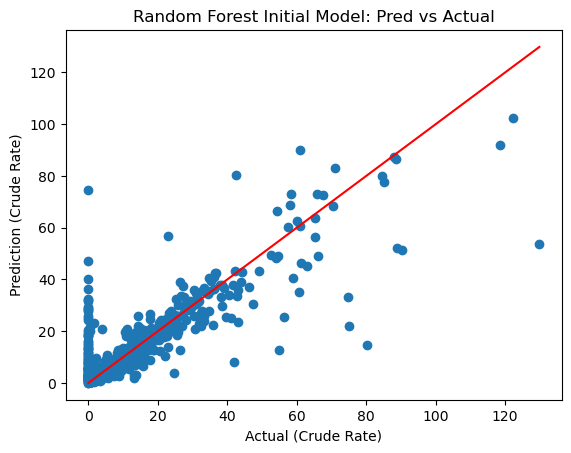

Elapsed time to compute the importances: 6.266 seconds


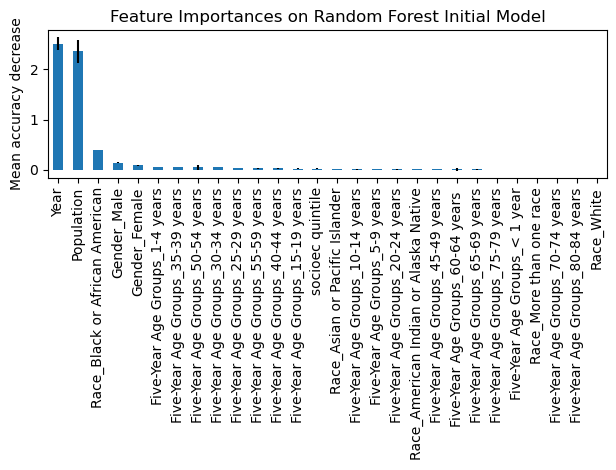

In [205]:
y_pred = rf_base.predict(x_test)
evaluate_model(y_pred, y_test['Crude Rate'], model_name = rf_base_name, x_test = x_test)
rate_features_permutation(rf_base, x_train, x_test, y_pred, model_name = rf_base_name)

In [206]:
# Best random forest
# hyperparameter tuning
param_grid = { 
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' :['friedman_mse', 'squared_error']
}


In [207]:

random_forest_tuner = RandomForestRegressor(random_state = seed)

start_time = datetime.now()
random_forest_grid = GridSearchCV(estimator=random_forest_tuner, param_grid=param_grid, cv=5)
random_forest_grid.fit(x_train, y_train['Crude Rate'])
print('Time to find best random forest parameters: ') # takes around 20 minutes
timer(start_time)

Time to find best random forest parameters: 
0.0 : 2.0 : 54.16


In [208]:
print(random_forest_grid.best_params_)
print(random_forest_grid.best_score_)
random_forest_grid

{'criterion': 'friedman_mse', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 500}
0.5080263474540253


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 200, 500]})

In [209]:
best_rf = RandomForestRegressor(random_state = seed, criterion = 'friedman_mse', 
                                max_depth = 8, max_features = 'sqrt', n_estimators = 500)
best_rf

RandomForestRegressor(criterion='friedman_mse', max_depth=8,
                      max_features='sqrt', n_estimators=500, random_state=0)

In [210]:
best_rf.fit(x_train, y_train['Crude Rate'])

RandomForestRegressor(criterion='friedman_mse', max_depth=8,
                      max_features='sqrt', n_estimators=500, random_state=0)

In [211]:
best_rf.feature_importances_

array([0.27411909, 0.28423141, 0.03325234, 0.04196717, 0.04560185,
       0.06559366, 0.02919388, 0.0373391 , 0.00384105, 0.0299117 ,
       0.01086112, 0.01081765, 0.0090782 , 0.00266814, 0.0045402 ,
       0.01352491, 0.01014741, 0.00986407, 0.00195055, 0.00480249,
       0.01173932, 0.00851856, 0.00638006, 0.00792873, 0.00481771,
       0.01844707, 0.01417568, 0.00468687])

RMSE for Random Forest Best Model is 9.5244
Not None


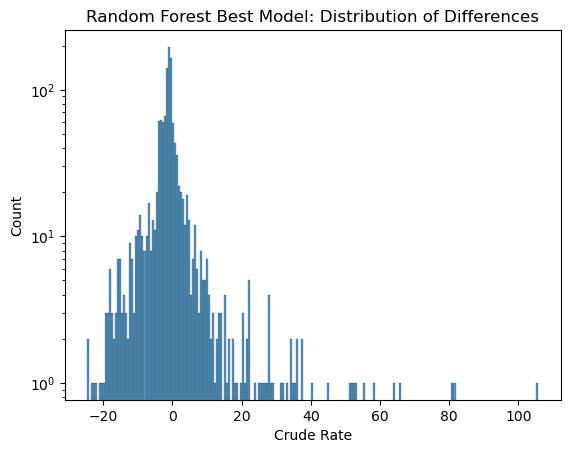

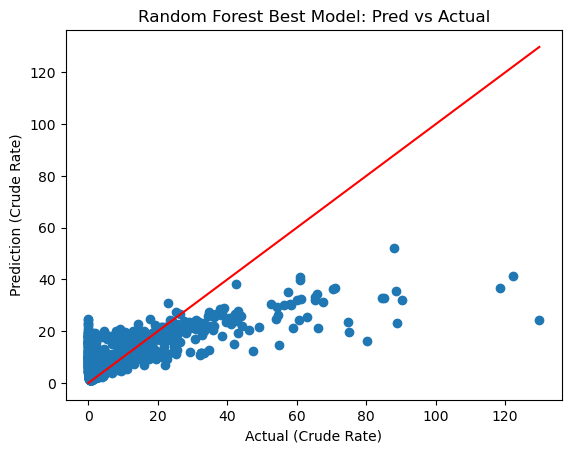

Elapsed time to compute the importances: 9.961 seconds


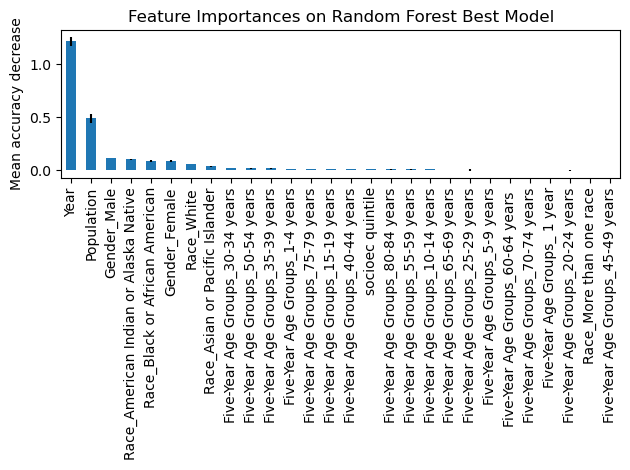

In [326]:
x_test = x_test.rename(columns = {'Five-Year Age Groups_ 1 year': 'Five-Year Age Groups_< 1 year'}) #renamed back to w/"<" b/c had to rerun after XGBoost changes
y_pred = best_rf.predict(x_test)
best_rf_name = 'Random Forest Best Model'
evaluate_model(y_pred, y_test['Crude Rate'], model_name = best_rf_name, x_test = x_test)
rate_features_permutation(best_rf, x_train, x_test, y_pred, model_name = best_rf_name)

# XGBoost

In [213]:
x_train.columns = x_train.columns.str.replace('<','')
x_test.columns = x_test.columns.str.replace('<','')
x_train

,Year,Population,socioec quintile,Gender_Female,Gender_Male,Race_American Indian or Alaska Native,Race_Asian or Pacific Islander,Race_Black or African American,Race_More than one race,Race_White,...,Five-Year Age Groups_45-49 years,Five-Year Age Groups_5-9 years,Five-Year Age Groups_50-54 years,Five-Year Age Groups_55-59 years,Five-Year Age Groups_60-64 years,Five-Year Age Groups_65-69 years,Five-Year Age Groups_70-74 years,Five-Year Age Groups_75-79 years,Five-Year Age Groups_80-84 years,Five-Year Age Groups_ 1 year
30562,2021,70101,2.0,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
34324,2021,109245,5.0,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
9350,2006,206667,2.0,True,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
33087,2021,135795,4.0,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4439,2017,47309,1.0,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31820,2021,12280,3.0,False,True,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
26963,2019,354381,5.0,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9458,2008,1818406,2.0,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
21067,2016,205131,4.0,True,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False


RMSE for XGBoost Base Model is 7.4708
Not None


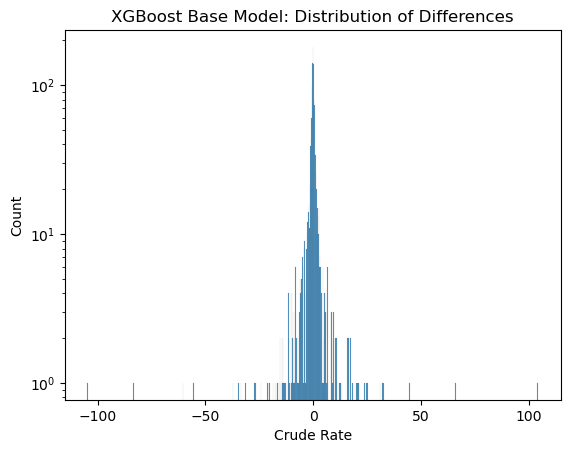

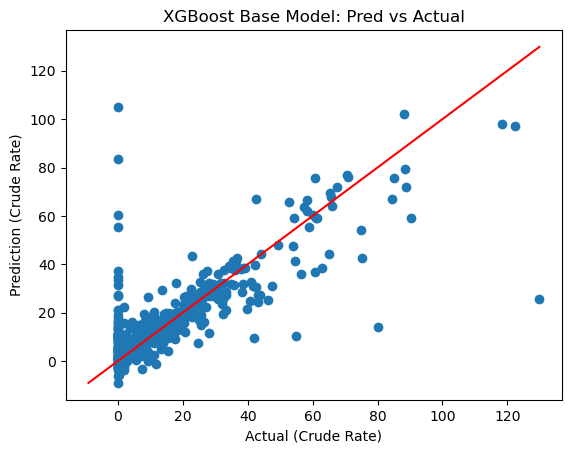

Elapsed time to compute the importances: 0.747 seconds


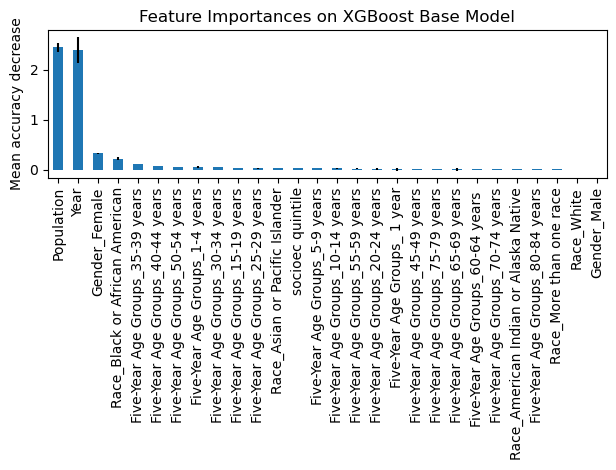

In [214]:
boost = XGBRegressor(random_state = seed)
boost.fit(x_train, y_train['Crude Rate'])
boost_base_name = 'XGBoost Base Model'
y_pred = boost.predict(x_test)
evaluate_model(y_pred, y_test['Crude Rate'], boost_base_name,  x_test = x_test)
rate_features_permutation(boost, x_train, x_test, y_pred, model_name = boost_base_name)

In [215]:
# Best XGBoost model
# params = { 'max_depth': [3,6,10],
#            'learning_rate': [0.01, 0.05, 0.1],
#            'n_estimators': [100, 500, 1000],
#            'colsample_bytree': [0.3, 0.7]}

params_boost = { 'max_depth': [5, 10, 20], # [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.5],  #, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
#            'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

RMSE for XGBoost Best Model is 6.3181
Not None


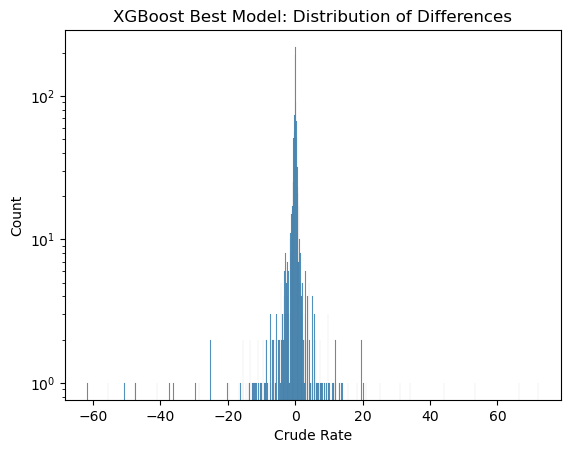

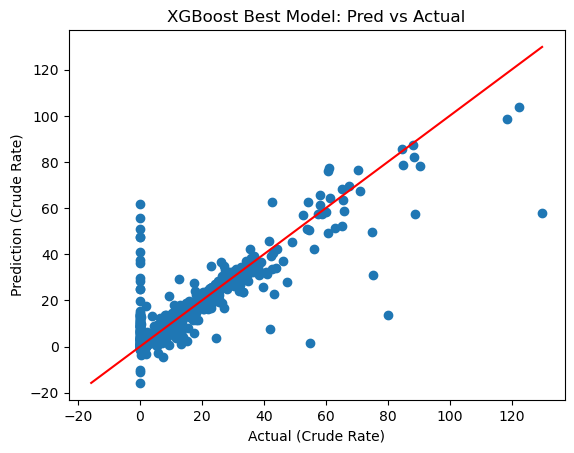

Elapsed time to compute the importances: 3.104 seconds


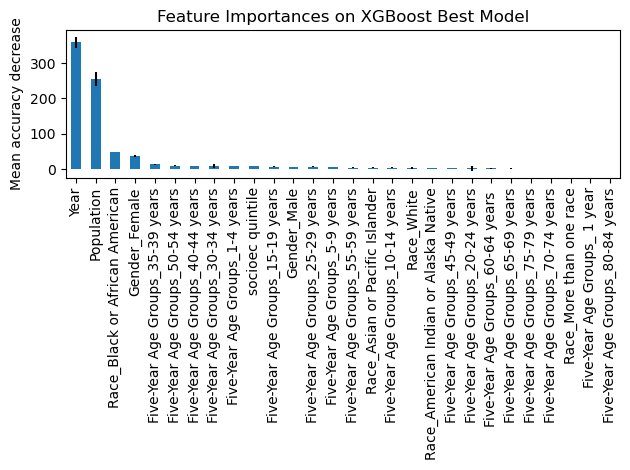

Time to find best XGBoost parameters: 
2.0 : 15.0 : 34.3


In [216]:
# estimated at 3 hours - 6 fits per second for 64800 fits... 
# in reality, was taking beyond 16 hours...
boost_best_mod = XGBRegressor(random_state = seed)
boost_base_name = 'XGBoost Best Model'
start_time = datetime.now()
best_boost = GridSearchCV(estimator=boost_best_mod, 
                   param_grid=params_boost,
                   scoring='neg_mean_squared_error')
#                    verbose=1)

best_boost.fit(x_train, y_train['Crude Rate'])
y_pred = best_boost.predict(x_test)
evaluate_model(y_pred, y_test['Crude Rate'], boost_base_name,  x_test = x_test)
rate_features_permutation(best_boost, x_train, x_test, y_pred, model_name = boost_base_name)
print('Time to find best XGBoost parameters: ') 
timer(start_time)

In [217]:
params_boost = { 'max_depth': [5, 10, 20], # [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.5],  #, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
#            'colsample_bytree': np.arange(0.4, 1.0, 0.1),
#            'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

Best parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.8999999999999999}
Best estimator:  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)
RMSE for XGBoost Best Model is 7.421
Not None


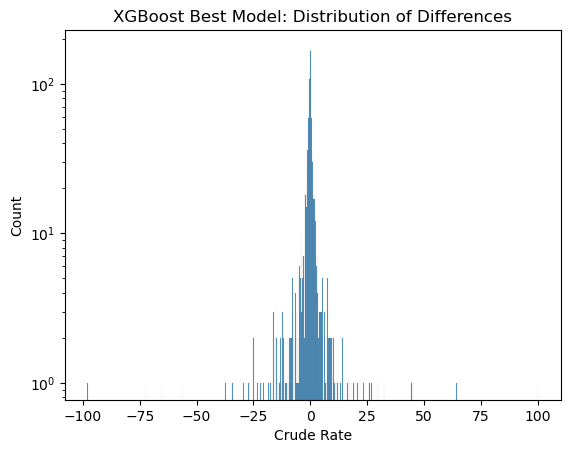

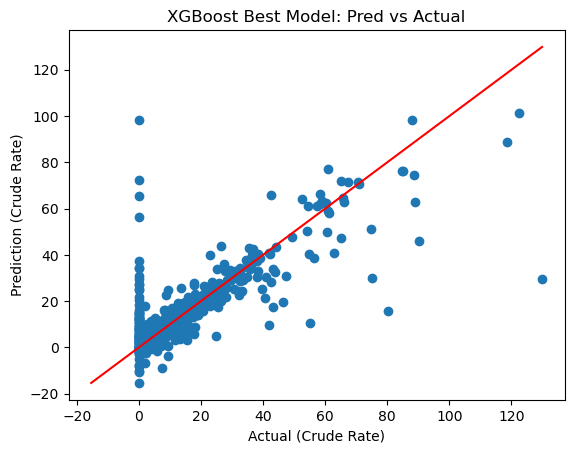

Elapsed time to compute the importances: 2.765 seconds


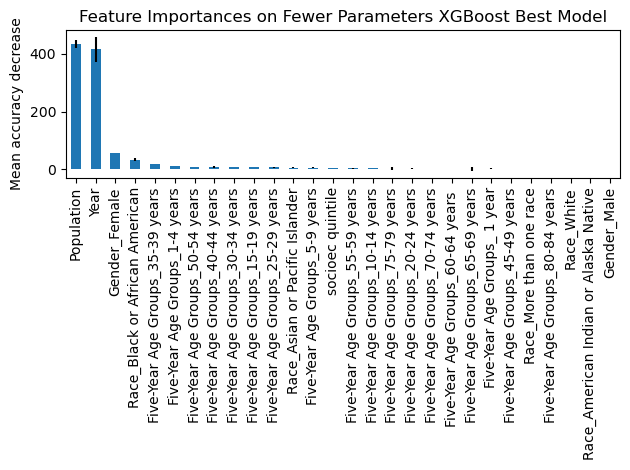

Time to find best XGBoost parameters: 
0.0 : 22.0 : 28.45


In [225]:
# with the smaller set of params, takes only 16 minutes
boost_best_mod_short = XGBRegressor(random_state = seed)
boost_base_name = 'XGBoost Best Model'
start_time = datetime.now()
best_boost_short = GridSearchCV(estimator=boost_best_mod_short, 
                   param_grid=params_boost,
                   scoring='neg_mean_squared_error')
#                    verbose=1)



best_boost_short.fit(x_train, y_train['Crude Rate'])
print("Best parameters: ", best_boost_short.best_params_)
print("Best estimator: ", best_boost_short.best_estimator_)
y_pred = best_boost_short.predict(x_test)
evaluate_model(y_pred, y_test['Crude Rate'], boost_base_name,  x_test = x_test)
rate_features_permutation(best_boost_short, x_train, x_test, y_pred, model_name = "Fewer Parameters "+boost_base_name)
print('Time to find best XGBoost parameters: ') 
timer(start_time)

### Predict on LA
Using Los Angeles County, show how to use the model

In [286]:
# read in data, massage a bit
start_time = datetime.now()
la_county = pd.read_csv('cleaned_wonder_LA_County_2021.csv')
# la_county['Crude Rate'] = la_county['Crude Rate'].fillna(0) # .replace(0, 0.001)
la_county['Crude Rate'] = (100000 * la_county['Deaths'] )/ la_county['Population'] 
la_county['Crude Rate'].value_counts()

Crude Rate
7.421469    2
5.480935    2
3.838551    2
5.578303    2
4.372297    2
           ..
3.854411    1
4.218504    1
3.920902    1
4.469059    1
5.076941    1
Name: count, Length: 342, dtype: int64

In [241]:
la_county

,Multiple Cause of death,Multiple Cause of death Code,Year,Year Code,Gender,Gender Code,Five-Year Age Groups,Five-Year Age Groups Code,Deaths,Population,Crude Rate,socioec quintile,Race,Race Code,age_midpoint
0,Heroin,T40.1,2021,2021,Male,M,25-29 years,25-29,17,271509,6.261303,4,White,2106-3,27
1,Heroin,T40.1,2021,2021,Male,M,30-34 years,30-34,23,288549,7.970917,4,White,2106-3,32
2,Heroin,T40.1,2021,2021,Male,M,35-39 years,35-39,15,263352,5.695799,4,White,2106-3,37
3,Heroin,T40.1,2021,2021,Male,M,45-49 years,45-49,12,230527,5.205464,4,White,2106-3,47
4,Heroin,T40.1,2021,2021,Male,M,50-54 years,50-54,12,240500,4.989605,4,White,2106-3,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,Other synthetic narcotics,T40.4,2020,2020,Male,M,45-49 years,45-49,53,235955,22.461910,4,White,2106-3,47
348,Other synthetic narcotics,T40.4,2020,2020,Male,M,50-54 years,50-54,49,237310,20.648097,4,White,2106-3,52
349,Other synthetic narcotics,T40.4,2020,2020,Male,M,55-59 years,55-59,37,223598,16.547554,4,White,2106-3,57
350,Other synthetic narcotics,T40.4,2020,2020,Male,M,60-64 years,60-64,23,195537,11.762480,4,White,2106-3,62


In [277]:
la_county['Five-Year Age Groups'].value_counts()

Five-Year Age Groups
45-49 years     54
50-54 years     50
40-44 years     48
30-34 years     45
35-39 years     45
25-29 years     32
55-59 years     32
20-24 years     23
60-64 years     16
15-19 years      5
65-69 years      2
Name: count, dtype: int64

In [318]:
# filter to fentanyl and split to x, y dfs
fentanyl_la = la_county[la_county['Multiple Cause of death'] == 'Other synthetic narcotics'].copy()
fentanyl_bronze_la = fentanyl_la.loc[:, np.append(x_cols, y_col)].copy() #or #fentanyl_outliers_removed.copy()
# fentanyl_bronze.reset_index(inplace = True, drop = True).drop()
fentanyl_bronze_la

fentanyl_silver_la = pd.get_dummies(fentanyl_bronze_la)

fentanyl_silver_la
fentanyl_silver_la.columns = fentanyl_silver_la.columns.str.replace('<', '') # this removes all cols with just False
# fentanyl_silver_la.columns 

# x_la is missing dummy columns that the trained data has, because 2021 has different information and county-specific pull may not
# have had rows for specific values, e.g.  'Five-Year Age Groups_< 1 year', 'Race_American Indian or Alaska Native'
missing_cols = list(x_train.columns.difference(fentanyl_silver_la.columns)) 
# append missing columns with False to fit into model schema
for col in missing_cols:
    fentanyl_silver_la[col] = False

fentanyl_silver_la = fentanyl_silver_la.rename(columns = {'Five-Year Age Groups_< 1 year': 'Five-Year Age Groups_ 1 year'})   
fentanyl_silver_la
fentanyl_silver_la


x_la = fentanyl_silver_la.drop(y_col, axis = 1) # get only features
# reorder feature names to match the feature order that was used to train the models
model_col_order = x_train.columns #similar to pickle packages': #best_boost.get_booster().feature_names
x_la = x_la[model_col_order]

y_la = fentanyl_silver_la.loc[:, y_col]

x_la
# y_la




,Year,Population,socioec quintile,Gender_Female,Gender_Male,Race_American Indian or Alaska Native,Race_Asian or Pacific Islander,Race_Black or African American,Race_More than one race,Race_White,...,Five-Year Age Groups_45-49 years,Five-Year Age Groups_5-9 years,Five-Year Age Groups_50-54 years,Five-Year Age Groups_55-59 years,Five-Year Age Groups_60-64 years,Five-Year Age Groups_65-69 years,Five-Year Age Groups_70-74 years,Five-Year Age Groups_75-79 years,Five-Year Age Groups_80-84 years,Five-Year Age Groups_ 1 year
10,2021,218776,4,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
11,2021,227125,4,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
12,2021,266742,4,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
13,2021,270306,4,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
14,2021,240029,4,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,2020,240499,4,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
347,2020,235955,4,False,True,False,False,False,False,True,...,True,False,False,False,False,False,False,False,False,False
348,2020,237310,4,False,True,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
349,2020,223598,4,False,True,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False


In [319]:
x_la.columns.difference(x_train)

Index(['Five-Year Age Groups_ 1 year', 'Five-Year Age Groups_1-4 years',
       'Five-Year Age Groups_10-14 years', 'Five-Year Age Groups_15-19 years',
       'Five-Year Age Groups_20-24 years', 'Five-Year Age Groups_25-29 years',
       'Five-Year Age Groups_30-34 years', 'Five-Year Age Groups_35-39 years',
       'Five-Year Age Groups_40-44 years', 'Five-Year Age Groups_45-49 years',
       'Five-Year Age Groups_5-9 years', 'Five-Year Age Groups_50-54 years',
       'Five-Year Age Groups_55-59 years', 'Five-Year Age Groups_60-64 years ',
       'Five-Year Age Groups_65-69 years', 'Five-Year Age Groups_70-74 years',
       'Five-Year Age Groups_75-79 years', 'Five-Year Age Groups_80-84 years',
       'Gender_Female', 'Gender_Male', 'Population',
       'Race_American Indian or Alaska Native',
       'Race_Asian or Pacific Islander', 'Race_Black or African American',
       'Race_More than one race', 'Race_White', 'Year', 'socioec quintile'],
      dtype='object')

In [313]:
x_train.columns.difference(x_la)

Index(['Five-Year Age Groups_ 1 year', 'Five-Year Age Groups_1-4 years',
       'Five-Year Age Groups_10-14 years', 'Five-Year Age Groups_15-19 years',
       'Five-Year Age Groups_20-24 years', 'Five-Year Age Groups_25-29 years',
       'Five-Year Age Groups_30-34 years', 'Five-Year Age Groups_35-39 years',
       'Five-Year Age Groups_40-44 years', 'Five-Year Age Groups_45-49 years',
       'Five-Year Age Groups_5-9 years', 'Five-Year Age Groups_50-54 years',
       'Five-Year Age Groups_55-59 years', 'Five-Year Age Groups_60-64 years ',
       'Five-Year Age Groups_65-69 years', 'Five-Year Age Groups_70-74 years',
       'Five-Year Age Groups_75-79 years', 'Five-Year Age Groups_80-84 years',
       'Gender_Female', 'Gender_Male', 'Population',
       'Race_American Indian or Alaska Native',
       'Race_Asian or Pacific Islander', 'Race_Black or African American',
       'Race_More than one race', 'Race_White', 'Year', 'socioec quintile'],
      dtype='object')

In [310]:
x_train

,Year,Population,socioec quintile,Gender_Female,Gender_Male,Race_American Indian or Alaska Native,Race_Asian or Pacific Islander,Race_Black or African American,Race_More than one race,Race_White,...,Five-Year Age Groups_45-49 years,Five-Year Age Groups_5-9 years,Five-Year Age Groups_50-54 years,Five-Year Age Groups_55-59 years,Five-Year Age Groups_60-64 years,Five-Year Age Groups_65-69 years,Five-Year Age Groups_70-74 years,Five-Year Age Groups_75-79 years,Five-Year Age Groups_80-84 years,Five-Year Age Groups_ 1 year
30562,2021,70101,2.0,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
34324,2021,109245,5.0,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
9350,2006,206667,2.0,True,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
33087,2021,135795,4.0,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4439,2017,47309,1.0,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31820,2021,12280,3.0,False,True,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
26963,2019,354381,5.0,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9458,2008,1818406,2.0,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
21067,2016,205131,4.0,True,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False


RMSE for LA County XGBoost Best Model is 13.6653
Not None


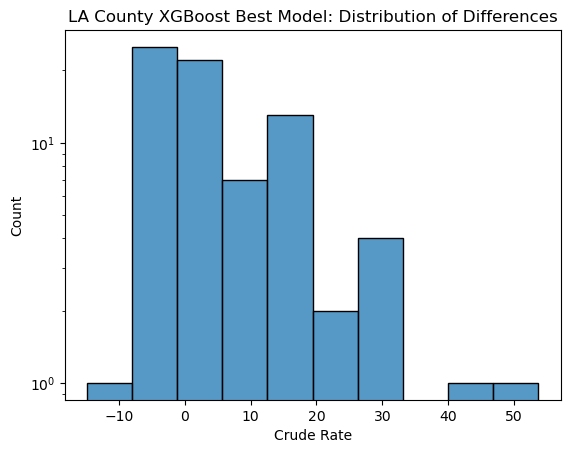

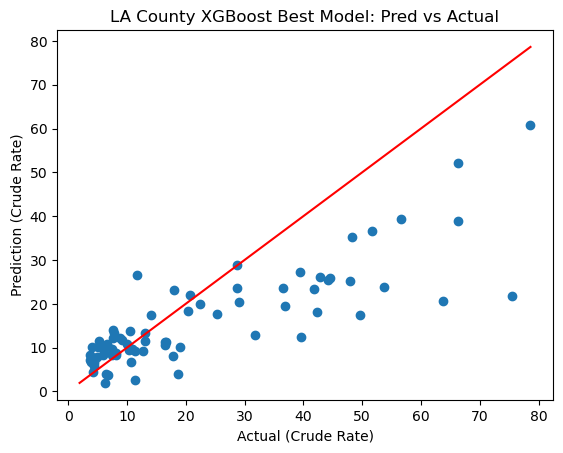

Elapsed time to compute the importances: 0.698 seconds


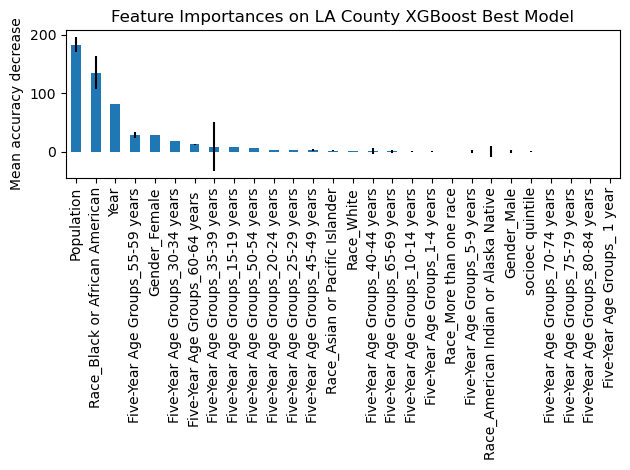

Time to evaluate model on LA: 
0.0 : 30.0 : 5.16


In [336]:
# evaluate model on LA data
y_pred_la = best_boost.predict(x_la)
evaluate_model(y_pred_la, y_la['Crude Rate'], "LA County " + boost_base_name,  x_test = x_la)
rate_features_permutation(best_boost, x_train, x_la, y_pred_la, model_name = "LA County " + boost_base_name)
print('Time to evaluate model on LA: ') 
timer(start_time)

(6658,)

RMSE for LA County XGBoost Best Model is 13.6653
Not None


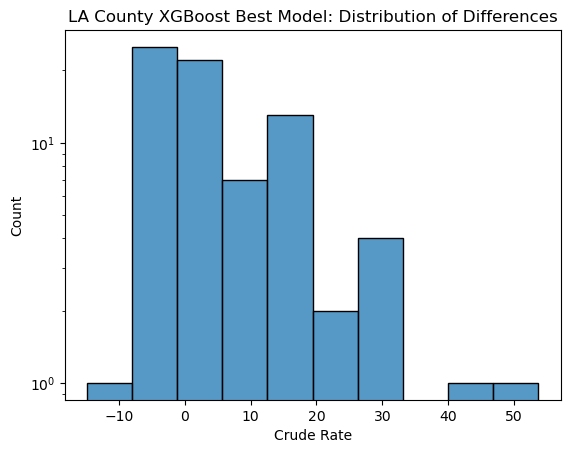

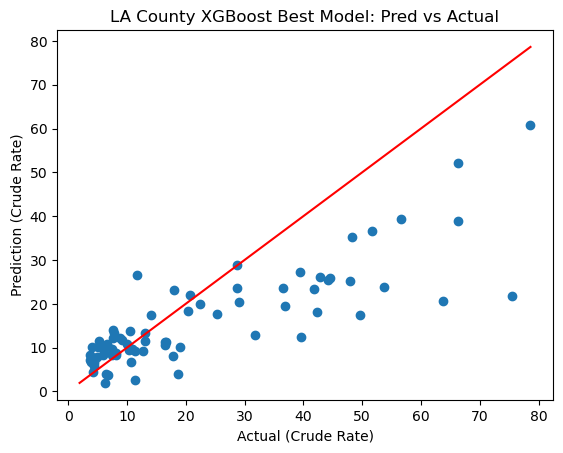

Elapsed time to compute the importances: 0.660 seconds


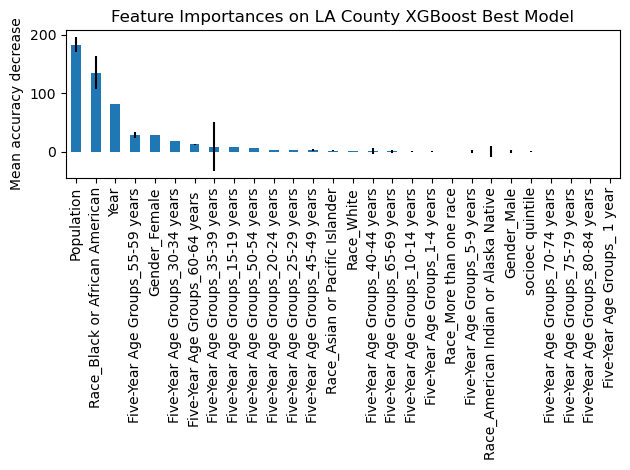

Time to evaluate model on LA: 
0.0 : 30.0 : 10.02


In [337]:
# evaluate xgboost chosen from shorter list of parameters on LA data (faster train)

y_pred_la = best_boost_short.predict(x_la)
evaluate_model(y_pred_la, y_la['Crude Rate'], "LA County " + boost_base_name,  x_test = x_la)
rate_features_permutation(best_boost, x_train, x_la, y_pred_la, model_name = "LA County " + boost_base_name)
print('Time to evaluate model on LA: ') 
timer(start_time)

RMSE for LA County Random Forest Best Model is 16.3891
Not None


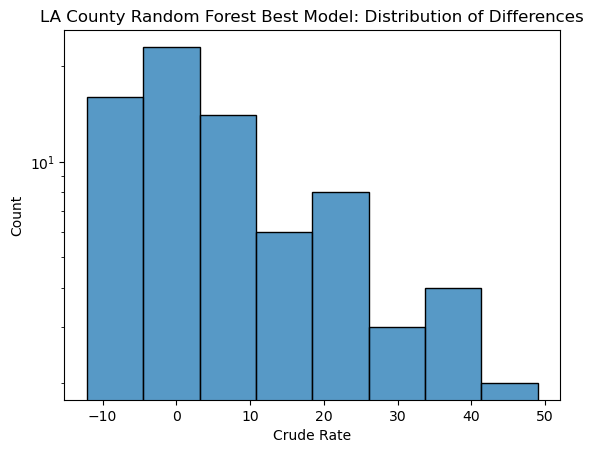

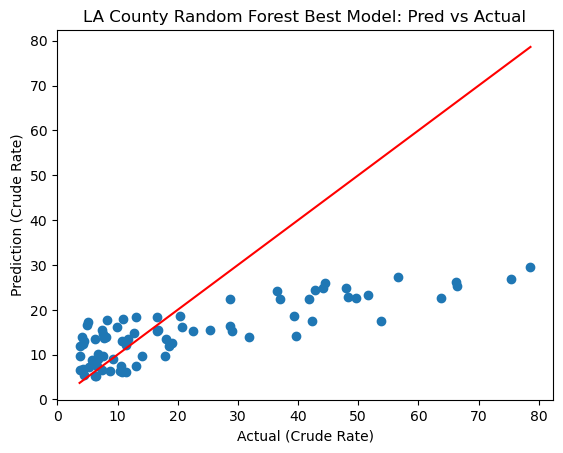

Elapsed time to compute the importances: 3.100 seconds


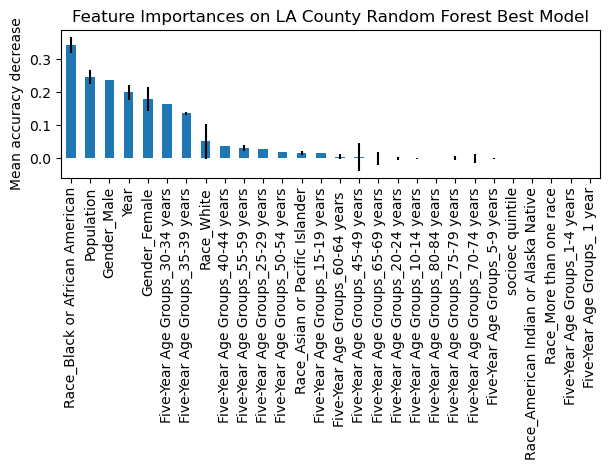

In [339]:
# evaluate best random forest chosen from shorter list of parameters on LA data (faster train)
x_la_for_rf = x_la.rename(columns = {'Five-Year Age Groups_ 1 year': 'Five-Year Age Groups_< 1 year'}) #renamed back to w/"<" b/c had to rerun after XGBoost changes
y_pred = best_rf.predict(x_la_for_rf)
best_rf_name = 'Random Forest Best Model'
evaluate_model(y_pred, y_la['Crude Rate'], model_name = "LA County " +best_rf_name, x_test = x_la_for_rf)
rate_features_permutation(best_rf, x_train, x_la_for_rf, y_pred, model_name = "LA County " + best_rf_name)